## <span style="color:blue;">Notebook Contents</span>

### 1. Set up
  1. **Loading packages**
  2. **Connecting with GPUs**
### 2. Data Preparation
  1. **Unzipping and reorganizing data for DataLoaders**
  2. **Creating DataLoaders**
  3. **Plotting sample images** 
### 3. Resnet50 model fine tuning
  1. **Loading Resnet50**
  2. **Exploring model architecture**
  3. **Model finetuning  and training**
### 4. Model evaluation
  1. **Model evaluation on test data**
  
<hr>

## 1. Set Up

### Loading packages

In [1]:
# utilities
import os
import shutil
import time
from collections import Counter

#numpy and pandas
import numpy as np
import pandas as pd

# sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# pytorch packages
import torch
from torch import tensor
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(torch.__version__)

2.5.1


### Connecting to GPU/MPS

<div style="color:red; font-size:16px; background-color:yellow;">RUN THIS BELOW BLOCK ONLY ON MACBOOK FOR A LOCAL INSTANCE</div>


In [4]:
# Run locally if Macbook has a GPU
# Is MPS even available? macOS 12.3+

print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

dtype = torch.float
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using GPU: Metal Performance Shaders (MPS)")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Tensor creation
x = tensor([1.0, 2.0, 3.0], device=device, dtype=dtype)
print(f"Tensor: {x}, Device: {x.device}")

True
True
Using GPU: Metal Performance Shaders (MPS)
Tensor: tensor([1., 2., 3.], device='mps:0'), Device: mps:0


## 2. Data Preparation

### Loading the data

In [26]:
# data source - https://www.kaggle.com/datasets/roudranildas/chicken-images-classification-dataset
!unzip data.zip

Archive:  data.zip
  inflating: data/chicken-images/data/test/0U5DJ4AHL7U8.jpg  
  inflating: data/chicken-images/data/test/0YRRH5UO983S.jpg  
  inflating: data/chicken-images/data/test/17ZH2WHTIPL8.jpg  
  inflating: data/chicken-images/data/test/1O9LZD4GDLEG.jpg  
  inflating: data/chicken-images/data/test/1OX6JD87ZL6M.jpg  
  inflating: data/chicken-images/data/test/1WHCYYP4QBBB.jpg  
  inflating: data/chicken-images/data/test/1ZLB7IELNMCD.jpg  
  inflating: data/chicken-images/data/test/21AEDSI4YQ9L.jpg  
  inflating: data/chicken-images/data/test/2GGVG9VUE5VP.jpg  
  inflating: data/chicken-images/data/test/2IH2F7SXSTFS.jpg  
  inflating: data/chicken-images/data/test/2MD30734HGEK.jpg  
  inflating: data/chicken-images/data/test/30XSIDP797YK.jpg  
  inflating: data/chicken-images/data/test/37ROYA9ANCBW.jpg  
  inflating: data/chicken-images/data/test/3LMOHKHBDS3X.jpg  
  inflating: data/chicken-images/data/test/3PAKQG6U95KF.jpg  
  inflating: data/chicken-images/data/test/40BAXGH6

In [27]:
# check the folder structure

print("📁 Folder structure under './data/'\n")
for root, dirs, files in os.walk("data"):
    indent = "  " * root.count(os.sep)
    print(f"{indent}📁 {os.path.basename(root)}")

📁 Folder structure under './data/'

📁 data
  📁 test
    📁 duck
    📁 chicken
  📁 duck-images
    📁 data
      📁 test
      📁 train
      📁 val
  📁 chicken-images
    📁 data
      📁 test
      📁 train
      📁 val
  📁 train
    📁 duck
    📁 chicken
  📁 val
    📁 duck
    📁 chicken


In [28]:
# restructring the data to make it work with dataloaders

def move_species_data(source_base, target_base, species_name):
    for split in ['train', 'val', 'test']:
        src = os.path.join(source_base, 'data', split)
        dst = os.path.join(target_base, split, species_name)
        os.makedirs(dst, exist_ok=True)

        for fname in os.listdir(src):
            fpath = os.path.join(src, fname)
            if os.path.isfile(fpath):
                shutil.move(fpath, os.path.join(dst, fname))

# Set paths
chicken_root = "data/chicken-images"
duck_root = "data/duck-images"
target_root = "data"

# Move files in-place
move_species_data(chicken_root, target_root, 'chicken')
move_species_data(duck_root, target_root, 'duck')

shutil.rmtree("data/chicken-images")
shutil.rmtree("data/duck-images")

In [29]:
class DataPrep:
    def __init__(self, data_path='data', batch_size=32, image_size=224):
        self.data_path = data_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.transform = self._get_transform()
        self._load_datasets()
        self._create_dataloaders()
        self._print_summary()
        self._inspect_batch()
        self._plot_class_distribution()

    def _get_transform(self):
        print("Creating transform pipeline")
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def _load_datasets(self):
        print(f"\nLoading datasets from '{self.data_path}'")
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_path, 'train'), transform=self.transform)
        self.val_dataset   = datasets.ImageFolder(os.path.join(self.data_path, 'val'), transform=self.transform)
        self.test_dataset  = datasets.ImageFolder(os.path.join(self.data_path, 'test'), transform=self.transform)

        print("Dataset sizes:")
        print(f"  - Train: {len(self.train_dataset)}")
        print(f"  - Val  : {len(self.val_dataset)}")
        print(f"  - Test : {len(self.test_dataset)}")

        print("\nClasses:", self.train_dataset.classes)
        print("Label mapping:", self.train_dataset.class_to_idx)

    def _create_dataloaders(self):
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.val_loader   = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        self.test_loader  = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        print("\nDataloaders created.")

    def _print_summary(self):
        print("\nBatches per split:")
        print(f"  - Train: {len(self.train_loader)}")
        print(f"  - Val  : {len(self.val_loader)}")
        print(f"  - Test : {len(self.test_loader)}")

    def _inspect_batch(self):
        images, labels = next(iter(self.train_loader))
        print("\nFirst batch from training data loader:")
        print(f"  - Image batch shape: {images.shape}")
        print(f"  - Label batch shape: {labels.shape}")

    def _plot_class_distribution(self):
        def get_percentages(dataset):
            labels = [label for _, label in dataset.samples]
            total = len(labels)
            counts = Counter(labels)
            return {dataset.classes[k]: (v / total) * 100 for k, v in counts.items()}

        train_pct = get_percentages(self.train_dataset)
        val_pct   = get_percentages(self.val_dataset)
        test_pct  = get_percentages(self.test_dataset)

        labels = self.train_dataset.classes
        x = np.arange(len(labels))
        width = 0.25

        fig, ax = plt.subplots()
        ax.bar(x - width, [train_pct.get(cls, 0) for cls in labels], width, label='Train')
        ax.bar(x,         [val_pct.get(cls, 0) for cls in labels], width, label='Val')
        ax.bar(x + width, [test_pct.get(cls, 0) for cls in labels], width, label='Test')

        ax.set_ylabel('% of Samples')
        ax.set_title('Class Distribution by Dataset Split')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        for i, split_pct in enumerate([train_pct, val_pct, test_pct]):
            for j, cls in enumerate(labels):
                pct = split_pct.get(cls, 0)
                ax.text(x[j] + (i - 1)*width, pct + 0.5, f'{pct:.1f}%', ha='center', fontsize=8)

        plt.ylim(0, 100)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()    

Creating transform pipeline

Loading datasets from './data'
Dataset sizes:
  - Train: 897
  - Val  : 161
  - Test : 482

Classes: ['chicken', 'duck']
Label mapping: {'chicken': 0, 'duck': 1}

Dataloaders created.

Batches per split:
  - Train: 29
  - Val  : 6
  - Test : 16

First batch from training data loader:
  - Image batch shape: torch.Size([32, 3, 224, 224])
  - Label batch shape: torch.Size([32])


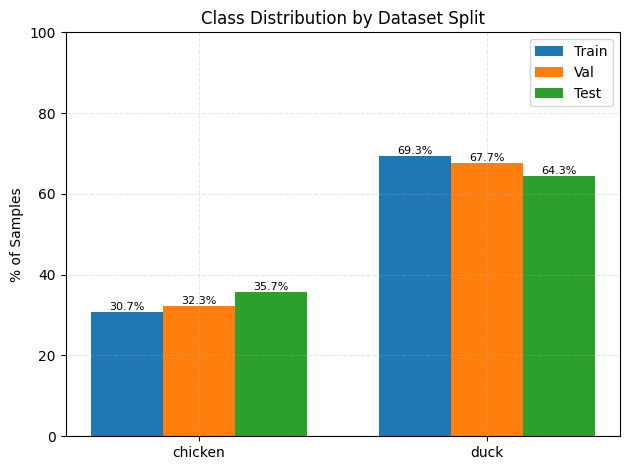

In [30]:
prep = DataPrep(data_path='./data', batch_size=32)

### Plotting samples

In [31]:
def show_samples(prep):
    def get_sample(dataset, class_idx):
        for path, label in dataset.samples:
            if label == class_idx:
                img = Image.open(path).convert("RGB")
                return prep.transform(img)
        return None

    splits = [
        ("Train", prep.train_dataset),
        ("Val", prep.val_dataset),
        ("Test", prep.test_dataset)
    ]
    classes = prep.train_dataset.classes
    class_to_idx = prep.train_dataset.class_to_idx

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 9))

    for row, (split_name, dataset) in enumerate(splits):
        for col, class_name in enumerate(classes):
            class_idx = class_to_idx[class_name]
            img = get_sample(dataset, class_idx)
            if img is None:
                continue
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img = torch.clamp(img, 0, 1)
            npimg = img.numpy()
            axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))
            axes[row, col].set_title(f"{split_name} - {class_name}")
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

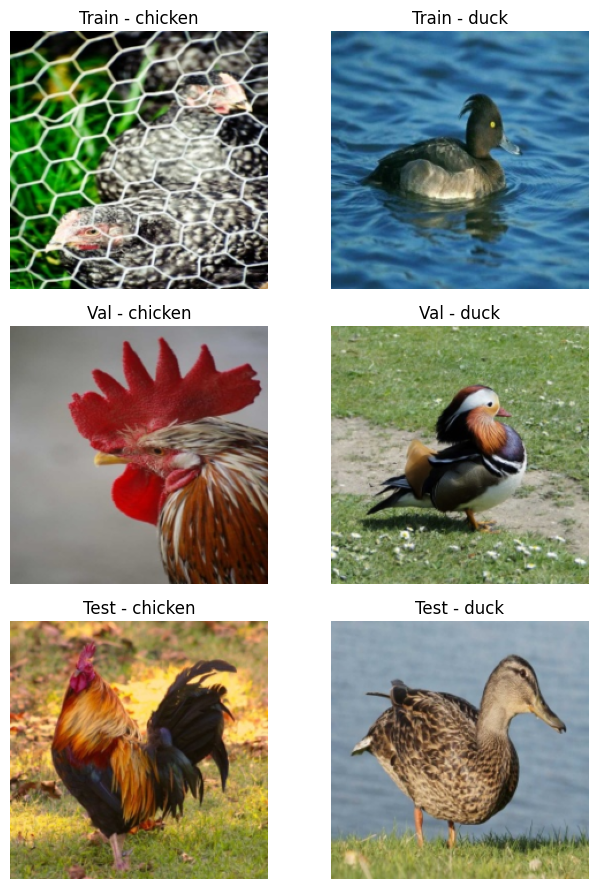

In [32]:
show_samples(prep)

In [33]:
# classes = ('Amphibian', 'Animalia', 'Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia')

## 3. Model finetuning

### Downloading ResNet50

In [34]:
resnet50 = models.resnet50(pretrained = True)

### Exploring the model architecture

In [35]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
for i, att in enumerate(dir(resnet50)):
    print(f"{i} : {att}")

0 : T_destination
1 : __annotations__
2 : __call__
3 : __class__
4 : __delattr__
5 : __dict__
6 : __dir__
7 : __doc__
8 : __eq__
9 : __format__
10 : __ge__
11 : __getattr__
12 : __getattribute__
13 : __getstate__
14 : __gt__
15 : __hash__
16 : __init__
17 : __init_subclass__
18 : __le__
19 : __lt__
20 : __module__
21 : __ne__
22 : __new__
23 : __reduce__
24 : __reduce_ex__
25 : __repr__
26 : __setattr__
27 : __setstate__
28 : __sizeof__
29 : __str__
30 : __subclasshook__
31 : __weakref__
32 : _apply
33 : _backward_hooks
34 : _backward_pre_hooks
35 : _buffers
36 : _call_impl
37 : _compiled_call_impl
38 : _forward_hooks
39 : _forward_hooks_always_called
40 : _forward_hooks_with_kwargs
41 : _forward_impl
42 : _forward_pre_hooks
43 : _forward_pre_hooks_with_kwargs
44 : _get_backward_hooks
45 : _get_backward_pre_hooks
46 : _get_name
47 : _is_full_backward_hook
48 : _load_from_state_dict
49 : _load_state_dict_post_hooks
50 : _load_state_dict_pre_hooks
51 : _make_layer
52 : _maybe_warn_non_fu

In [37]:
for name, layer in resnet50.named_children():
    if name.startswith("layer"):
        print(f'{name} contains {len(list(layer))} blocks')

layer1 contains 3 blocks
layer2 contains 4 blocks
layer3 contains 6 blocks
layer4 contains 3 blocks


In [38]:
for i, block in enumerate(resnet50.layer4):
    print(f"Block {i+1} details :")
    for name, module in block.named_modules():
        print(f" {name}  : {module}")
        print("------")
          

Block 1 details :
   : Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
------
 conv1  : Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
------
 bn1  : BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
------
 conv2  : Conv2d(512, 512, kernel_siz

In [39]:
print("Details of blocks in layer4:")
for i, block in enumerate(resnet50.layer4):
    print(f"Block {i+1}:")
    print(block)  
    print("-----" )

Details of blocks in layer4:
Block 1:
Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
-----
Block 2:
Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Con

### Finetuning ResNet50


In [40]:
# Create the model instance
resnet50_ft = models.resnet50(pretrained=True)
out_classes = 2

# Modify the final classification layer
resnet50_ft.fc = nn.Linear(resnet50_ft.fc.in_features, out_classes)

# Freeze all layers
for param in resnet50_ft.parameters():
    param.requires_grad = False

# Unfreeze the final residual block for fine-tuning
for param in resnet50_ft.layer4.parameters():
    param.requires_grad = True

### Loss function and Optimizer

In [41]:
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_ft.parameters(),lr=0.001, momentum = 0.9)

In [42]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs=1):

    model.to(device)
    torch.manual_seed(7)  # Set random seed for reproducibility
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_correct = 0.0
        total_samples = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accuracy
            class_correct = torch.argmax(outputs, axis=1) == labels
            running_correct += torch.count_nonzero(class_correct)
            total_samples += labels.size(0)

        # Metrics for the epoch
        epoch_loss = running_loss / total_samples
        epoch_accuracy = running_correct / total_samples

        print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_loss:.3f}, Training Accuracy: {epoch_accuracy:.3f}')

    total_time = time.time() - start_time
    print(f"\nTraining completed in: {total_time:.2f} seconds")
    return model

In [43]:
trained_model = train_model(
    model=resnet50_ft,
    train_loader=prep.train_loader,
    optimizer=optimizer,
    criterion=Loss,
    device=device,
    num_epochs=5
)

Epoch 1/5 - Training Loss: 0.742, Training Accuracy: 0.405
Epoch 2/5 - Training Loss: 0.436, Training Accuracy: 0.831
Epoch 3/5 - Training Loss: 0.237, Training Accuracy: 0.958
Epoch 4/5 - Training Loss: 0.174, Training Accuracy: 0.962
Epoch 5/5 - Training Loss: 0.115, Training Accuracy: 0.978

Training completed in: 19.60 seconds


### Model evaluation

In [44]:
def evaluate_model(model, data_loader, criterion, class_names, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_correct = 0.0
    total_samples = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            preds = torch.argmax(outputs, axis=1)
            class_correct = preds == labels
            running_correct += torch.count_nonzero(class_correct)
            total_samples += labels.size(0)

            # Collect predictions for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Average loss and accuracy
    avg_loss = running_loss/total_samples
    accuracy = running_correct / total_samples

    # Overall metrics
    print("\nOverall Metrics:")
    print(f'Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

     # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()



Overall Metrics:
Loss: 0.042, Accuracy: 0.965

Classification Report:
              precision    recall  f1-score   support

     chicken      0.987     0.913     0.949       172
        duck      0.954     0.994     0.973       310

    accuracy                          0.965       482
   macro avg      0.970     0.953     0.961       482
weighted avg      0.966     0.965     0.964       482



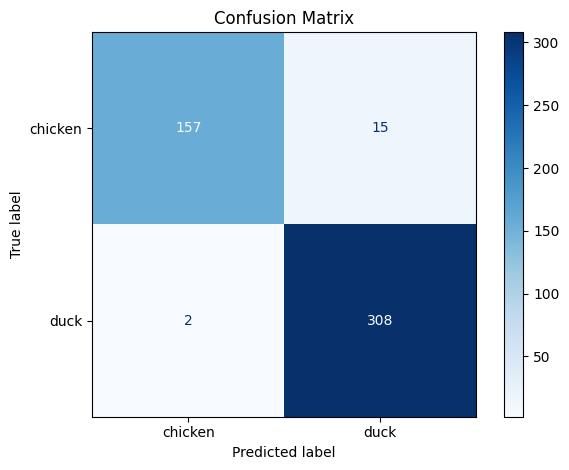

In [45]:
evaluate_model(model=trained_model, data_loader=prep.test_loader, criterion=Loss, class_names=prep.train_dataset.classes, device=device)